In [1]:
import numpy as np

# Parámetros
data_bits = 12       # resolución del DAC / tamaño de cada valor
addr_bits = 10       # número de direcciones de la LUT
n_points = 2**addr_bits  # 1024 posiciones

# Generar ángulos de 0 a 2π
theta = np.linspace(0, 2*np.pi, n_points, endpoint=False)

# Generar valores del seno, escalados a 0..2^data_bits-1
sine_values = np.round((np.sin(theta) + 1) * (2**data_bits - 1)/2).astype(int)

# Guardar en archivo .hex
with open("sine_table.hex", "w") as f:
    for val in sine_values:
        f.write(f"{val:03x}\n")  # formato hexadecimal, 3 dígitos para 12 bits

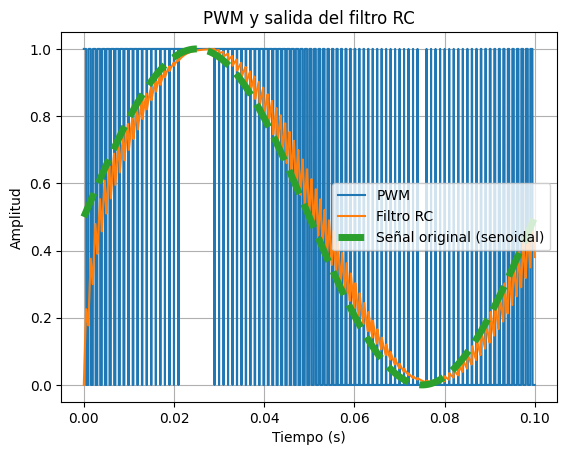

In [22]:
import numpy as np
import random
import matplotlib.pyplot as plt

f_sin = 10        # frecuencia de la señal senoidal
f_pwm = 1e3           # frecuencia del PWM
fs = 100 * f_pwm           # frecuencia de muestreo, 100 muestras por ciclo de PWM
duty = 0.5            # duty cycle 50%
RC = 2000e-6             # constante de tiempo del filtro
T = 0.1            # tiempo total de simulación
N = int(T * fs)


t = np.arange(N)/fs

sin = (np.sin(2 * np.pi * f_sin * t) + 1) / 2  # Señal senoidal entre 0 y 1

# PWM
pwm = np.zeros(N)
for i in range(N):
    duty = sin[i]
    if np.mod(t[i]*f_pwm, 1) < duty:
        pwm[i] = 1.0
    else:
        pwm[i] = 0.0

# Filtro RC
v_out = np.zeros(N)
alpha = 1/(RC*fs)
for n in range(1, N):
    v_out[n] = v_out[n-1] + alpha*(pwm[n]-v_out[n-1])

plt.plot(t, pwm, label='PWM')
plt.plot(t, v_out, label='Filtro RC')
plt.plot(t, sin, label='Señal original (senoidal)', linestyle='--', linewidth=5)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid()
plt.title('PWM y salida del filtro RC')
# size bigger
# plt.figure(figsize=(12, 6))
# save figure
plt.savefig('pwm_rc_filter.png')
plt.show()


# PWM Samples

In [3]:
with open("samples.txt", "r") as f:
    data = f.read()
samples = data.replace('[', '').replace(']', '').split(',')
samples = [int(s) for s in samples]

#samples is a list
print(type(samples))
# print(samples)
print(len(samples))

<class 'list'>
2116776


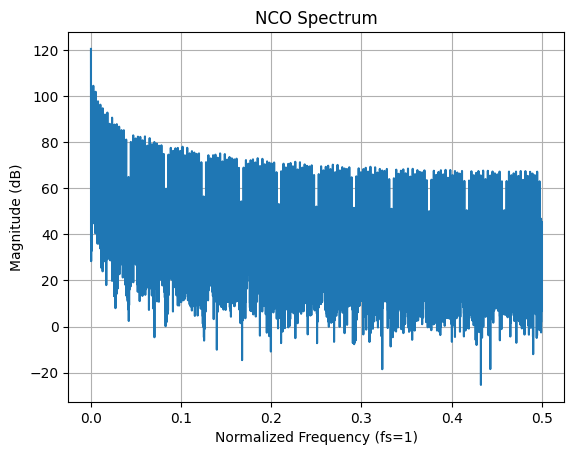

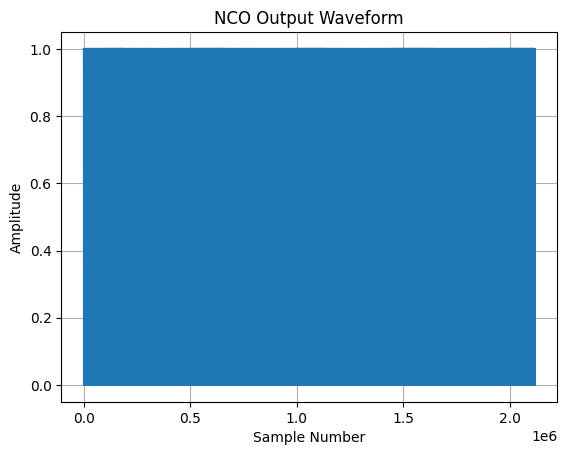

In [4]:
import numpy as np
import matplotlib.pyplot as plt
samples = np.array(samples)
spectrum = np.fft.fft(samples)
freq = np.fft.fftfreq(len(samples))
plt.plot(freq[:len(freq)//2], 20*np.log10(np.abs(spectrum[:len(spectrum)//2])))
plt.title("NCO Spectrum")
plt.xlabel("Normalized Frequency (fs=1)")
plt.ylabel("Magnitude (dB)")
plt.grid()
plt.savefig("nco_output_spectrum.png")
plt.show()
plt.close()


plt.plot(samples)  # plot first 1000 samples
plt.title("NCO Output Waveform")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.grid()

plt.show()

2116776
2116776
0.002


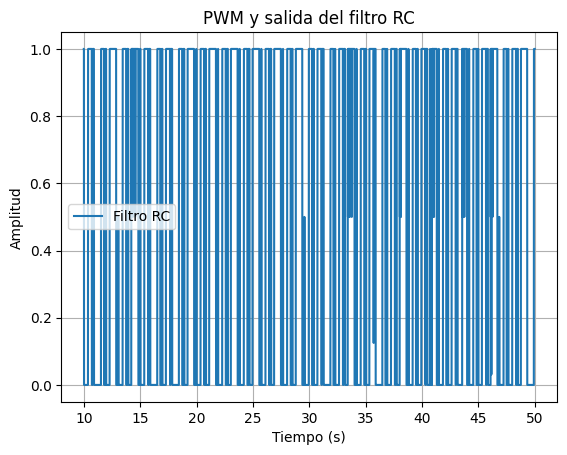

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# PWM
pwm = samples
f_pwm = 1e3           # frecuencia del PWM
RC = 2000e-6             # constante de tiempo del filtro
# RC_VALUES = [100e-6, 500e-6, 1000e-6, 2000e-6, 5000e-6]
N = len(pwm)
print(N)

t = np.arange(N)/f_pwm
print(len(t))

# Filtro RC
v_out = np.zeros(N)

# for RC in RC_VALUES:
alpha = 1/(RC*f_pwm)
for n in range(1, N):
    v_out[n] = v_out[n-1] + alpha*(pwm[n]-v_out[n-1])
print(RC)
# vout complete to .txt
# with open("vout.txt", "w") as f:
#     for val in v_out:
#         f.write(f"{val}\n")


# plt.plot(t, pwm, label='PWM')
plt.plot(t[10000:50000], v_out[10000:50000], label='Filtro RC')
# plt.plot(t, sin, label='Señal original (senoidal)', linestyle='--')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid()
plt.title('PWM y salida del filtro RC')
# size bigger
# plt.figure(figsize=(12, 6))
# save figure
plt.savefig('pwm_rc_filter.png')
plt.show()

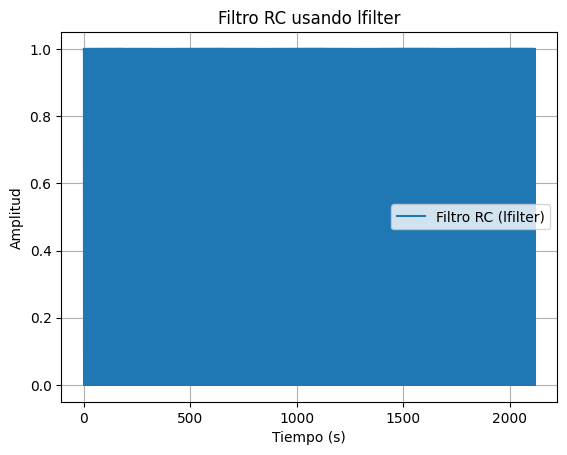

In [6]:
from scipy.signal import lfilter
import matplotlib.pyplot as plt

RC = 1000e-6             # constante de tiempo del filtro

alpha = 1/(RC*f_pwm)
b = [alpha]
a = [1, -(1-alpha)]
v_out = lfilter(b, a, pwm)

plt.plot(t, v_out, label='Filtro RC (lfilter)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid()
plt.title('Filtro RC usando lfilter')
plt.show()



In [ ]:
import numpy as np
import scipy.io.wavfile as wav

# Cargar tu señal filtrada (lista, numpy array, archivo txt, lo que sea)
v_out = v_out  # Aquí debes poner tu señal filtrada

# Normalización de amplitud
v = v_out - np.mean(v_out)         # quitar DC
v = v / np.max(np.abs(v))          # normalizar a [-1..1]
wav_data = (v * 32767).astype(np.int16)

# ⚠️ FUNDAMENTAL: frecuencia de muestreo REAL del PWM filtrado
fs = 687280

wav.write("output.wav", fs, wav_data)

print("Listo! output.wav generado")


Listo! output.wav generado


In [3]:
import numpy as np
from scipy.io import wavfile

# Configuración
INPUT_WAV = "input.wav"
OUTPUT_HEX = "audio_table.hex"
DATA_BITS = 12
MAX_VAL = (2**DATA_BITS - 1) # 4095

# 1. Cargar WAV
samplerate, audio = wavfile.read(INPUT_WAV)
print(f"Frecuencia de muestreo original: {samplerate} Hz")
print(f"Cantidad de muestras original: {len(audio)}")

# 2. Convertir a mono si es estéreo
if audio.ndim > 1:
    audio = audio.mean(axis=1)

# 3. Normalizar a -1..1
audio = audio.astype(np.float32)
max_abs = np.max(np.abs(audio))
if max_abs > 0:
    audio /= max_abs

# 4. Escalar a 0..4095 (Sin resamplear)
#    Simplemente transformamos los valores existentes
audio_scaled = np.round((audio + 1) * MAX_VAL / 2).astype(int)
audio_scaled = np.clip(audio_scaled, 0, MAX_VAL)

# 5. Guardar en HEX
print("Guardando archivo HEX (esto puede tardar si el audio es largo)...")
with open(OUTPUT_HEX, "w") as f:
    # for val in audio_scaled[:len(audio_scaled)//4]:
    for val in audio_scaled:
        f.write(f"{val:03x}\n")

print(f"¡Listo! Archivo generado: {OUTPUT_HEX}")
print(f"Total de líneas en HEX: {len(audio_scaled)}")

Frecuencia de muestreo original: 44100 Hz
Cantidad de muestras original: 88200
Guardando archivo HEX (esto puede tardar si el audio es largo)...
¡Listo! Archivo generado: audio_table.hex
Total de líneas en HEX: 88200


In [4]:
import numpy as np
from scipy.io import wavfile

# Configuración
INPUT_HEX = "audio_table.hex"
OUTPUT_WAV = "audio_reconstruido.wav"
SAMPLERATE = 44100  # <--- ¡Pon aquí el valor que imprimió el primer script!
DATA_BITS = 12
MAX_VAL = (2**DATA_BITS - 1)

print("Leyendo archivo HEX...")

try:
    # 1. Leer HEX
    with open(INPUT_HEX, "r") as f:
        hex_data = [line.strip() for line in f if line.strip()]
    
    # Convertir a enteros
    int_data = np.array([int(val, 16) for val in hex_data], dtype=np.float32)
    print(f"Muestras recuperadas: {len(int_data)}")

    # 2. Desescalar (De 0..4095 a -1..1)
    # Fórmula: x = (y * 2 / MAX_VAL) - 1
    audio_recovered = (int_data * 2 / MAX_VAL) - 1.0

    # 3. Guardar WAV
    wavfile.write(OUTPUT_WAV, SAMPLERATE, audio_recovered)
    print(f"¡Éxito! Audio guardado en: {OUTPUT_WAV}")

except FileNotFoundError:
    print("Error: No se encuentra el archivo .hex")

Leyendo archivo HEX...
Muestras recuperadas: 88200
¡Éxito! Audio guardado en: audio_reconstruido.wav
